In [1]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re
from common import *

In [2]:
chromosome = 10

In [3]:
data = []

cluster_added = {}

for alpha in [75, 108]:
    files = [f for f in glob.glob(f"output/A1_chr{chromosome}_gamma*_alpha{alpha}_*.txt") if not "partitions" in f]
    #print(files)

    gamma_re = re.compile(r".+gamma(\d+)_")
    gammas = sorted(set(gamma_re.match(file).group(1) for file in files), key=int)

    modularity = pd.read_csv(f"matlab/output/A1_chr{chromosome}_alpha{alpha}_modularity.csv", sep=" ", header=None).T

    for file in files:
        name_parts = file.split("gamma")[1]
        cluster = int(name_parts.split("_")[-1].split(".")[0])
        gamma = name_parts.split("_", maxsplit=1)[0]

        gamma_idx = gammas.index(gamma)
        q = modularity[gamma_idx].iloc[cluster]

        df = pd.read_csv(file, sep=" ", names=["module", "node", "level1"])
        significant = df.module[~df.module.str.endswith(";")]
        num_significant = len(significant)
        num_nodes = len(df)

        fraction_significant = num_significant / num_nodes

        clusters = pd.read_csv(f"output/A1_chr{chromosome}_gamma{gamma}_alpha{alpha}_partitions.txt", sep=" ", comment="#")
        cluster_size = clusters.ClusterId.value_counts().to_frame().loc[cluster + 1].ClusterId

        df = pd.read_csv(f"matlab/output/A1_chr{chromosome}_gamma{gamma}_alpha{alpha}_partitions.csv", sep=" ", header=None)
        df = df.apply(lambda x: x.value_counts())
        df = df.apply(lambda x: effective_size(x[~np.isnan(x)]), raw=True)

        data.append({
                "$\\alpha$": f"{alpha / 100}",
                "$\gamma$": str(int(gamma) / 100),
                "fraction of core nodes": fraction_significant,
                "fraction of fringe nodes": 1 - fraction_significant,
                "eff. community size (Mb)": df.mean() / 10,
                "cluster": cluster,
                "cluster size": cluster_size,
                "$Q$": q,
                "$Q_{rel}$": q / modularity[gamma_idx].max(),
            })

df = pd.DataFrame(data)
df.head()

,$\alpha$,$\gamma$,fraction of core nodes,fraction of fringe nodes,eff. community size (Mb),cluster,cluster size,$Q$,$Q_{rel}$
0,0.75,1.75,0.879794,0.120206,0.536284,0,545,0.351025,1.000000
1,0.75,1.75,0.886431,0.113569,0.536284,10,103,0.350946,0.999775
2,0.75,1.15,0.838496,0.161504,1.821570,0,103,0.541554,1.000000
3,0.75,1.15,0.856932,0.143068,1.821570,1,113,0.541233,0.999406
4,0.75,1.65,0.901180,0.098820,0.669751,0,568,0.371284,1.000000


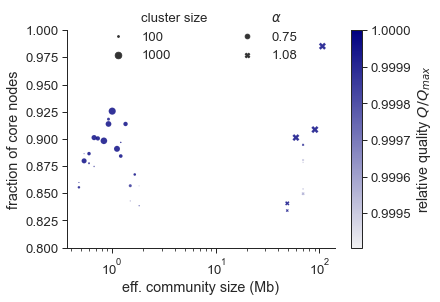

In [4]:
import matplotlib.colors as colors
import matplotlib.ticker as ticker
palette = sns.light_palette("navy", reverse=False, as_cmap=True)
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)

ax = sns.scatterplot(df[df["cluster size"] >= 100],
                     x="eff. community size (Mb)",
                     y="fraction of core nodes",
                     style="$\\alpha$",
                     hue="$Q_{rel}$",
                     size="cluster size",
                     sizes=(1, 50),
                     palette=palette,
                     edgecolor=palette(100),
                     alpha=0.8,
                     legend="brief")
sns.despine()
plt.ylim([0.8, 1])
plt.semilogx()


norm = plt.Normalize(df["$Q_{rel}$"].min(), df["$Q_{rel}$"].max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])
cb = ax.figure.colorbar(sm, label="relative quality $Q/Q_{max}$")#, format=ticker.LogFormatter(minor_thresholds=(1, 0.9995)))

h, l = ax.get_legend_handles_labels()
h = [*h[6:8], *h[12:]]
l = [*l[6:8], *l[12:]]
l[1] = "100"
l[2] = "1000"

ax.legend(handles=h, labels=l)
sns.move_legend(ax, "lower center", ncol=2, title=None, frameon=False, bbox_to_anchor=(0.5, 0.8))

#plt.savefig("results/fraction_core.pdf", dpi=600, bbox_inches="tight")